In [9]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import os

%matplotlib inline

In [8]:
!pip install --upgrade --force-reinstall opencv-python --user

  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
  Using cached numpy-1.22.3-cp38-cp38-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.64
    Uninstalling opencv-python-4.5.5.64:
      Successfully uninstalled opencv-python-4.5.5.64

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Jack Xu\\AppData\\Roaming\\Python\\Python38\\site-packages\\~v2\\cv2.pyd'
Check the permissions.



### Pattern Matching Threshold Analysis

In [14]:
def pattern_matching(img, template, method, show_img = False):
    
    h, w = template.shape
    img2 = img.copy()

    result = cv2.matchTemplate(img2, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        location = min_loc
        score = min_val
    else:
        location = max_loc
        score = max_val
    
    if show_img:
        bottom_right = (location[0] + w, location[1] + h)    
        cv2.rectangle(img2, location, bottom_right, 255, 5)
        plt.imshow(img2)
        
    return img2, location, score

In [15]:
# Read in greyscale mode
img = cv2.imread('img/whole_img_2.png', 0)
img_o = cv2.imread('img/other_img.png', 0)
img_b = cv2.imread('img/whole_img_bn.png', 0)

template = cv2.imread('img/countdown_new.png', 0)
template_resized = cv2.resize(template, (0,0), fx = 0.5, fy = 0.5)

template_bn = cv2.imread('img/combat.png', 0)
template_bn_resized = cv2.resize(template_bn, (0,0), fx = 0.5, fy = 0.5)

methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
            cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

1.0

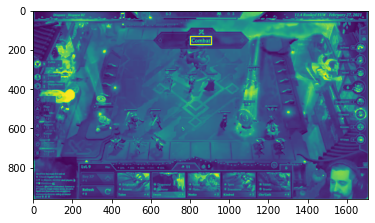

In [16]:
matched_img, location, score = pattern_matching(img_b, template_bn, methods[1], True)
score

0.8939361572265625

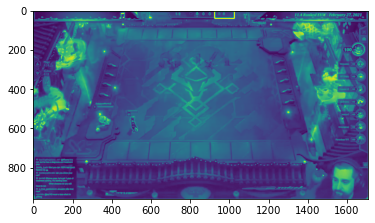

In [185]:
matched_img, location, score = pattern_matching(img, template, methods[1], True)
score

0.5489937663078308

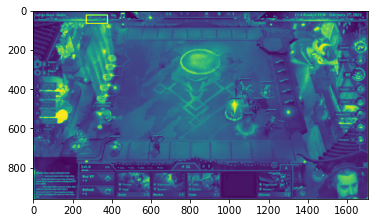

In [166]:
matched_img, location, score = pattern_matching(img_o, template, methods[1], True)
score

### Video Reading by Frames

Riot UI changed after April 15. 
*New* pattern matching technique needed.

In [19]:
cap = cv2.VideoCapture('contents/BoxBox/[Beginner Friendly] I make the BIGGEST blunder of my TFT career.mp4')

In [20]:
# Get fps for frame skipping
fps = cap.get(cv2.CAP_PROP_FPS)
print(cap.grab())

True


In [30]:
tic = time.perf_counter() # Time the code

count, skip_frames = 0, fps
combat_flag = False
combat_timestamp = 0
while cap.isOpened():
    ret,frame = cap.read()
    
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Match combat banner
        if not combat_flag:
            matched_img, location, score = pattern_matching(frame_gray, template_bn_resized, methods[1], False)
            if score > 0.90:
                combat_flag = True 
                combat_timestamp = count
                print(f"flag found at {combat_timestamp/fps} seconds")
        
        # Start looking for essential frame within 3s of founding the combat_timestamp
        elif combat_flag and count < combat_timestamp + fps * 10:
            matched_img, location, score = pattern_matching(frame_gray, template_resized, methods[1], False)
            if score > 0.88:
                cv2.imwrite("img/9/frame%d.jpg" % count, frame)
                combat_flag = False
                print(f"screen captured at {count/fps} seconds")
                count += fps * 9 # Forward 10s to avoid miss capturing 
        else:
            combat_flag = False # Reset the flag if out of bound

        count += skip_frames # This advances one second @ fps
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    else:
        cap.release()
        break
        
toc = time.perf_counter()
print(f"Finished the video in {toc - tic:0.4f} seconds")

Finished the video in 0.0003 seconds


### Frame Capturing based on combat flag only

In [38]:
# Some youtuber like to speed up their videos
skip_frame_dic = {"Milk" : 3.6, "else" : 4.5}
Hifu_video_path = 'contents/BoxBox/BoxBox teaches a Master Class on TFT unit swapping.mp4'
Hifu_img_path = 'img/BoxBox/3-star Alistar is so BIG! 8 second AoE stun theres literally no counterplay except'

In [39]:
def frame_capture_flag(video_path, img_path,
                       threshold = 0.84, youtuber = "else"): # 0.84 to adopt for golden flag
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) 
    
    tic = time.perf_counter() # Time the code
    count, skip_frames = 0, fps
    combat_timestamp = 0
    while cap.isOpened():
        ret,frame = cap.read()

        if ret:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Match combat banner
            matched_img, location, score = pattern_matching(frame_gray, template_bn_resized, methods[1], False)
            if score > threshold: 
                
                print(f"flag found at {count/fps} seconds")
                
                cap.set(cv2.CAP_PROP_POS_FRAMES, count + skip_frame_dic[youtuber]*fps)
                _,frame = cap.read()
                cv2.imwrite(img_path + "/frame%d.jpg" % count, frame)

                count += skip_frames * 9 # Skip 10 skipframes 

            count += skip_frames # This advances one second @ fps
            cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        else:
            cap.release()
            break

    toc = time.perf_counter()
    print(f"Finished the video in {toc - tic:0.4f} seconds")

In [40]:
frame_capture_flag(Hifu_video_path, Hifu_img_path)

flag found at 67.0 seconds
flag found at 130.0 seconds
flag found at 174.0 seconds
flag found at 240.0 seconds
flag found at 305.0 seconds
flag found at 414.0 seconds
flag found at 467.0 seconds
flag found at 521.0 seconds
flag found at 571.0 seconds


KeyboardInterrupt: 

### Batch Loading

In [46]:
Youtuber = 'Milk'

In [48]:
for filename in os.listdir('contents/' + Youtuber):
    name, file_extension = os.path.splitext(filename)
    video_path, img_path = 'contents/' + Youtuber + '/' + filename, 'img/' + Youtuber + '/' +name
    os.mkdir(img_path)
    frame_capture_flag(video_path, img_path, youtuber = 'Milk')

flag found at 50.0 seconds
flag found at 84.0 seconds
flag found at 123.0 seconds
flag found at 171.0 seconds
flag found at 201.0 seconds
flag found at 267.0 seconds
flag found at 322.0 seconds
flag found at 398.0 seconds
flag found at 439.0 seconds
flag found at 498.0 seconds
flag found at 574.0 seconds
flag found at 626.0 seconds
flag found at 710.0 seconds
flag found at 772.0 seconds
flag found at 847.0 seconds
flag found at 932.0 seconds
flag found at 1006.0 seconds
flag found at 1044.0 seconds
flag found at 1093.0 seconds
flag found at 1157.0 seconds
flag found at 1208.0 seconds
flag found at 1275.0 seconds
flag found at 1331.0 seconds
flag found at 1411.0 seconds
flag found at 1459.0 seconds
Finished the video in 39.4788 seconds
flag found at 156.0 seconds
flag found at 205.0 seconds
flag found at 241.0 seconds
flag found at 304.0 seconds
flag found at 343.0 seconds
flag found at 408.0 seconds
flag found at 459.0 seconds
flag found at 554.0 seconds
flag found at 635.0 seconds
fla

Finished the video in 42.8429 seconds
flag found at 133.0 seconds
flag found at 167.0 seconds
flag found at 270.0 seconds
flag found at 377.0 seconds
flag found at 452.0 seconds
flag found at 501.0 seconds
flag found at 551.0 seconds
flag found at 614.0 seconds
flag found at 691.0 seconds
flag found at 775.0 seconds
flag found at 846.0 seconds
flag found at 939.0 seconds
flag found at 1000.0 seconds
flag found at 1064.0 seconds
flag found at 1172.0 seconds
flag found at 1261.0 seconds
flag found at 1312.0 seconds
flag found at 1362.0 seconds
flag found at 1415.0 seconds
flag found at 1515.0 seconds
flag found at 1551.0 seconds
flag found at 1644.0 seconds
flag found at 1772.0 seconds
Finished the video in 44.6332 seconds
flag found at 93.0 seconds
flag found at 133.0 seconds
flag found at 175.0 seconds
flag found at 233.0 seconds
flag found at 300.0 seconds
flag found at 399.0 seconds
flag found at 484.0 seconds
flag found at 586.0 seconds
flag found at 696.0 seconds
flag found at 784.

flag found at 400.0 seconds
flag found at 448.0 seconds
flag found at 509.0 seconds
flag found at 613.0 seconds
flag found at 679.0 seconds
flag found at 731.0 seconds
flag found at 779.0 seconds
flag found at 850.0 seconds
flag found at 943.0 seconds
flag found at 988.0 seconds
flag found at 1031.0 seconds
flag found at 1081.0 seconds
flag found at 1145.0 seconds
flag found at 1219.0 seconds
flag found at 1269.0 seconds
flag found at 1312.0 seconds
flag found at 1341.0 seconds
flag found at 1398.0 seconds
flag found at 1444.0 seconds
flag found at 1521.0 seconds
Finished the video in 36.3389 seconds
flag found at 57.0 seconds
flag found at 86.0 seconds
flag found at 117.0 seconds
flag found at 175.0 seconds
flag found at 232.0 seconds
flag found at 343.0 seconds
flag found at 425.0 seconds
flag found at 483.0 seconds
flag found at 561.0 seconds
flag found at 634.0 seconds
flag found at 682.0 seconds
flag found at 760.0 seconds
flag found at 867.0 seconds
flag found at 950.0 seconds
fl

flag found at 423.0 seconds
flag found at 473.0 seconds
flag found at 537.0 seconds
flag found at 615.0 seconds
flag found at 701.0 seconds
flag found at 738.0 seconds
flag found at 829.0 seconds
flag found at 886.0 seconds
flag found at 946.0 seconds
flag found at 1038.0 seconds
flag found at 1133.0 seconds
flag found at 1203.0 seconds
flag found at 1257.0 seconds
flag found at 1306.0 seconds
flag found at 1386.0 seconds
flag found at 1443.0 seconds
flag found at 1495.0 seconds
flag found at 1534.0 seconds
flag found at 1657.0 seconds
flag found at 1743.0 seconds
flag found at 1791.0 seconds
Finished the video in 43.7285 seconds
flag found at 55.0 seconds
flag found at 101.0 seconds
flag found at 130.0 seconds
flag found at 226.0 seconds
flag found at 303.0 seconds
flag found at 356.0 seconds
flag found at 395.0 seconds
flag found at 433.0 seconds
flag found at 471.0 seconds
flag found at 540.0 seconds
flag found at 633.0 seconds
flag found at 700.0 seconds
flag found at 753.0 seconds

flag found at 1208.0 seconds
flag found at 1255.0 seconds
flag found at 1314.0 seconds
flag found at 1361.0 seconds
flag found at 1400.0 seconds
flag found at 1444.0 seconds
flag found at 1484.0 seconds
flag found at 1532.0 seconds
flag found at 1603.0 seconds
Finished the video in 41.2622 seconds
flag found at 77.0 seconds
flag found at 115.0 seconds
flag found at 149.0 seconds
flag found at 186.0 seconds
flag found at 235.0 seconds
flag found at 299.0 seconds
flag found at 350.0 seconds
flag found at 391.0 seconds
flag found at 439.0 seconds
flag found at 505.0 seconds
flag found at 590.0 seconds
flag found at 656.0 seconds
flag found at 699.0 seconds
flag found at 768.0 seconds
flag found at 808.0 seconds
flag found at 845.0 seconds
flag found at 936.0 seconds
flag found at 998.0 seconds
flag found at 1106.0 seconds
flag found at 1157.0 seconds
flag found at 1210.0 seconds
flag found at 1276.0 seconds
flag found at 1324.0 seconds
flag found at 1380.0 seconds
flag found at 1406.0 sec

flag found at 1128.0 seconds
flag found at 1177.0 seconds
flag found at 1234.0 seconds
flag found at 1312.0 seconds
flag found at 1374.0 seconds
flag found at 1452.0 seconds
flag found at 1514.0 seconds
flag found at 1577.0 seconds
flag found at 1663.0 seconds
flag found at 1732.0 seconds
Finished the video in 47.4305 seconds
flag found at 87.0 seconds
flag found at 138.0 seconds
flag found at 183.0 seconds
flag found at 237.0 seconds
flag found at 295.0 seconds
flag found at 384.0 seconds
flag found at 440.0 seconds
flag found at 501.0 seconds
flag found at 551.0 seconds
flag found at 620.0 seconds
flag found at 710.0 seconds
flag found at 808.0 seconds
flag found at 866.0 seconds
flag found at 928.0 seconds
flag found at 972.0 seconds
flag found at 1032.0 seconds
flag found at 1094.0 seconds
flag found at 1197.0 seconds
flag found at 1296.0 seconds
flag found at 1352.0 seconds
flag found at 1398.0 seconds
flag found at 1458.0 seconds
flag found at 1515.0 seconds
flag found at 1600.0 

flag found at 1785.0 seconds
Finished the video in 44.8773 seconds
flag found at 46.0 seconds
flag found at 118.0 seconds
flag found at 172.0 seconds
flag found at 228.0 seconds
flag found at 292.0 seconds
flag found at 351.0 seconds
flag found at 398.0 seconds
flag found at 437.0 seconds
flag found at 492.0 seconds
flag found at 556.0 seconds
flag found at 635.0 seconds
flag found at 689.0 seconds
flag found at 741.0 seconds
flag found at 789.0 seconds
flag found at 848.0 seconds
flag found at 925.0 seconds
flag found at 1003.0 seconds
flag found at 1047.0 seconds
flag found at 1079.0 seconds
flag found at 1121.0 seconds
flag found at 1167.0 seconds
flag found at 1236.0 seconds
flag found at 1282.0 seconds
flag found at 1368.0 seconds
flag found at 1411.0 seconds
flag found at 1469.0 seconds
flag found at 1545.0 seconds
Finished the video in 38.5522 seconds
flag found at 25.0 seconds
flag found at 94.0 seconds
flag found at 202.0 seconds
flag found at 286.0 seconds
flag found at 328.0

### Problem Shooting

TypeError: Image data of dtype object cannot be converted to float

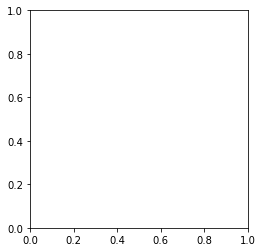

In [60]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 350 * fps)
ret,frame = cap.read()
plt.imshow(frame)

0.8490279316902161

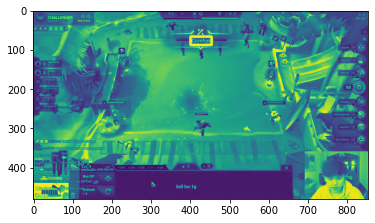

In [54]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
matched_img, location, score = pattern_matching(frame_gray, template_bn_resized, methods[1], True)
score

0.7968668937683105

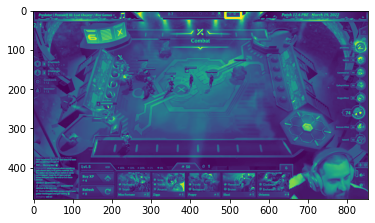

In [271]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
matched_img, location, score = pattern_matching(frame_gray, template_resized, methods[1], True)
score